# Taller 5: Métodos Computacionales en Modelos Lineales

## Descripción
Este taller se enfoca en los algoritmos y métodos computacionales utilizados para la estimación eficiente de modelos lineales. Exploraremos diferentes algoritmos de descomposición matricial, analizaremos su estabilidad numérica, eficiencia computacional y cómo estos afectan la precisión de nuestras estimaciones.

## Objetivos de Aprendizaje
- Comprender los principales algoritmos de descomposición matricial relevantes para modelos lineales
- Implementar diferentes métodos de inversión matricial desde cero
- Analizar la estabilidad numérica y eficiencia computacional de los algoritmos
- Evaluar el impacto del condicionamiento numérico en las estimaciones
- Desarrollar criterios para seleccionar el método computacional apropiado según el contexto

## Prerrequisitos
- Conocimientos de álgebra lineal básica
- Comprensión de los modelos lineales vistos en talleres anteriores
- Familiaridad con Python y NumPy

## Contenido
1. Introducción a la computación matricial
2. Descomposición LU
3. Descomposición de Cholesky
4. Descomposición QR
5. Descomposición SVD
6. Comparativa de métodos
7. Condicionamiento numérico
8. Aplicaciones a modelos lineales
9. Ejercicios prácticos


In [10]:
# Importación de librerías

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import linalg
import time
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Ignorar advertencias específicas
warnings.filterwarnings('ignore', category=RuntimeWarning)
np.set_printoptions(precision=4, suppress=True)

# Función para establecer una semilla aleatoria para reproducibilidad
def set_seed(seed=42):
    np.random.seed(seed)

set_seed()


## 1. Introducción a la Computación Matricial en Modelos Lineales

### 1.1 El problema computacional en modelos lineales

Recordemos que en el modelo lineal estándar:

$$\mathbf{y} = \mathbf{X}\boldsymbol{\beta} + \boldsymbol{\varepsilon}$$

donde $\mathbf{y} \in \mathbb{R}^n$ es el vector de respuestas, $\mathbf{X} \in \mathbb{R}^{n \times p}$ es la matriz de diseño, $\boldsymbol{\beta} \in \mathbb{R}^p$ es el vector de coeficientes, y $\boldsymbol{\varepsilon} \in \mathbb{R}^n$ es el vector de errores.

El estimador de mínimos cuadrados se define como:

$$\hat{\boldsymbol{\beta}} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y}$$

El cálculo directo de $(\mathbf{X}^T\mathbf{X})^{-1}$ presenta varios desafíos computacionales:

1. **Eficiencia computacional**: La inversión directa de matrices tiene una complejidad de $O(p^3)$, lo que puede ser ineficiente para matrices grandes.

2. **Estabilidad numérica**: La inversión directa puede amplificar errores de redondeo, especialmente cuando $\mathbf{X}^T\mathbf{X}$ está mal condicionada.

3. **Precisión**: Pequeños errores en el cálculo pueden propagarse y afectar significativamente la estimación de $\boldsymbol{\beta}$.

Para abordar estos desafíos, se utilizan métodos de descomposición matricial que permiten resolver sistemas lineales sin calcular explícitamente la inversa.

### 1.2 Importancia de métodos eficientes

Cuando trabajamos con conjuntos de datos de alta dimensión (muchas variables o muchas observaciones), la elección del método computacional es crucial por varias razones:

- **Tiempo de cómputo**: Métodos ineficientes pueden tomar horas o días para problemas grandes.
- **Uso de memoria**: Algunos algoritmos requieren almacenar matrices intermedias de gran tamaño.
- **Precisión numérica**: Los errores de redondeo se acumulan en cálculos matriciales extensos.

### 1.3 Ecuaciones normales vs. alternativas directas

El enfoque de las ecuaciones normales consiste en:
1. Formar $\mathbf{X}^T\mathbf{X}$ y $\mathbf{X}^T\mathbf{y}$
2. Resolver $(\mathbf{X}^T\mathbf{X})\boldsymbol{\beta} = \mathbf{X}^T\mathbf{y}$

Sin embargo, cuando formamos $\mathbf{X}^T\mathbf{X}$ explícitamente, podemos empeorar el condicionamiento de la matriz, ya que:

$$\kappa(\mathbf{X}^T\mathbf{X}) = \kappa(\mathbf{X})^2$$

donde $\kappa$ es el número de condición. Esto significa que los problemas numéricos se amplifican al cuadrado.

Los métodos alternativos que operan directamente sobre $\mathbf{X}$ (en lugar de $\mathbf{X}^T\mathbf{X}$) a menudo tienen mejor estabilidad numérica.

### 1.4 Solución de sistemas lineales vs. inversión matricial

En la práctica, rara vez necesitamos calcular explícitamente $(\mathbf{X}^T\mathbf{X})^{-1}$. Lo que realmente necesitamos es resolver el sistema:

$$\mathbf{X}^T\mathbf{X}\boldsymbol{\beta} = \mathbf{X}^T\mathbf{y}$$

Resolver un sistema lineal es generalmente más eficiente y numéricamente estable que calcular una inversa. Las descomposiciones matriciales que veremos nos permiten resolver estos sistemas sin calcular inversas explícitas.

En este taller, implementaremos y evaluaremos diferentes métodos de descomposición matricial para resolver el problema de mínimos cuadrados, comparándolos en términos de eficiencia y estabilidad numérica.


## 2. Descomposición LU

La descomposición LU (Lower-Upper) factoriza una matriz $\mathbf{A}$ como el producto de una matriz triangular inferior $\mathbf{L}$ y una matriz triangular superior $\mathbf{U}$:

$$\mathbf{A} = \mathbf{L}\mathbf{U}$$

### 2.1 Fundamentos teóricos

En el contexto de un sistema lineal $\mathbf{A}\mathbf{x} = \mathbf{b}$, la descomposición LU nos permite resolver el sistema en dos pasos:

1. Resolver $\mathbf{L}\mathbf{y} = \mathbf{b}$ para $\mathbf{y}$ (sustitución hacia adelante)
2. Resolver $\mathbf{U}\mathbf{x} = \mathbf{y}$ para $\mathbf{x}$ (sustitución hacia atrás)

La resolución de sistemas triangulares es computacionalmente eficiente, con complejidad $O(n^2)$ para una matriz de dimensión $n \times n$.

Para matrices no singulares, la descomposición LU siempre existe, pero para estabilidad numérica, generalmente se implementa con pivoteo parcial, resultando en:

$$\mathbf{P}\mathbf{A} = \mathbf{L}\mathbf{U}$$

donde $\mathbf{P}$ es una matriz de permutación.

### 2.2 Algoritmo de la descomposición LU

La descomposición LU se puede realizar mediante el algoritmo de eliminación gaussiana:

1. Para cada columna $k$ (desde 1 hasta $n-1$):
   a. Seleccionar el elemento pivote (el mayor en valor absoluto en la columna $k$ por debajo de la diagonal)
   b. Intercambiar filas si es necesario
   c. Para cada fila $i$ por debajo de $k$:
      - Calcular el multiplicador $m_{ik} = a_{ik}/a_{kk}$
      - Actualizar los elementos de la fila $i$: $a_{ij} = a_{ij} - m_{ik} \cdot a_{kj}$ para $j > k$
      - Almacenar el multiplicador en $L$: $l_{ik} = m_{ik}$

### 2.3 Implementación desde cero

Implementemos el algoritmo de descomposición LU con pivoteo parcial:


In [11]:
# Implementación de la descomposición LU desde cero

def lu_decomposition(A):
    """
    Realiza la descomposición LU con pivoteo parcial: PA = LU

    Args:
        A: Matriz cuadrada como array de NumPy

    Returns:
        P: Matriz de permutación
        L: Matriz triangular inferior con unos en la diagonal
        U: Matriz triangular superior
    """
    n = A.shape[0]

    # Creamos copias para no modificar la matriz original
    U = A.copy().astype(float)
    L = np.eye(n, dtype=float)
    P = np.eye(n, dtype=float)

    for k in range(n-1):
        # Encontrar el pivote máximo en la columna actual
        max_index = np.argmax(np.abs(U[k:, k])) + k

        # Si necesitamos intercambiar filas
        if max_index != k:
            # Intercambiar filas en U
            U[[k, max_index]] = U[[max_index, k]]

            # Intercambiar filas en L (solo las columnas 0 hasta k-1)
            if k > 0:
                L[[k, max_index], :k] = L[[max_index, k], :k]

            # Actualizar la matriz de permutación
            P[[k, max_index]] = P[[max_index, k]]

        # Eliminación gaussiana
        for i in range(k+1, n):
            # Calcular el factor para la fila i
            if U[k, k] == 0:
                L[i, k] = 0  # Evitar división por cero
            else:
                L[i, k] = U[i, k] / U[k, k]

            # Actualizar la fila i de U
            U[i, k:] = U[i, k:] - L[i, k] * U[k, k:]

            # Establecer explícitamente el valor eliminado a cero (para evitar errores de redondeo)
            U[i, k] = 0

    return P, L, U

def solve_lu(P, L, U, b):
    """
    Resuelve el sistema Ax = b usando la descomposición LU: PA = LU

    Args:
        P: Matriz de permutación
        L: Matriz triangular inferior
        U: Matriz triangular superior
        b: Vector del lado derecho

    Returns:
        x: Solución del sistema
    """
    # Aplicar permutación a b
    b_perm = P @ b

    # Resolver Ly = b_perm mediante sustitución hacia adelante
    n = L.shape[0]
    y = np.zeros(n)

    for i in range(n):
        y[i] = b_perm[i] - L[i, :i] @ y[:i]

    # Resolver Ux = y mediante sustitución hacia atrás
    x = np.zeros(n)

    for i in range(n-1, -1, -1):
        if U[i, i] == 0:
            raise ValueError("Matriz singular, no se puede resolver el sistema")
        x[i] = (y[i] - U[i, i+1:] @ x[i+1:]) / U[i, i]

    return x

# Función para resolver el modelo lineal usando LU
def linear_regression_lu(X, y):
    """
    Resuelve el problema de regresión lineal usando descomposición LU

    Args:
        X: Matriz de diseño
        y: Vector de respuestas

    Returns:
        beta: Coeficientes estimados
    """
    XtX = X.T @ X
    Xty = X.T @ y

    P, L, U = lu_decomposition(XtX)
    beta = solve_lu(P, L, U, Xty)

    return beta


Coeficientes verdaderos: [60.5775 98.6515 64.5917 57.0778 35.6097]
Coeficientes estimados (LU): [ 0.4121 61.4114 98.656  60.5544 55.3786 35.7713]
Tiempo de ejecución (LU): 0.001000 segundos
Coeficientes estimados (NumPy): [ 0.4121 61.4114 98.656  60.5544 55.3786 35.7713]
Tiempo de ejecución (NumPy): 0.000000 segundos
Error cuadrático medio (LU): 96.8997


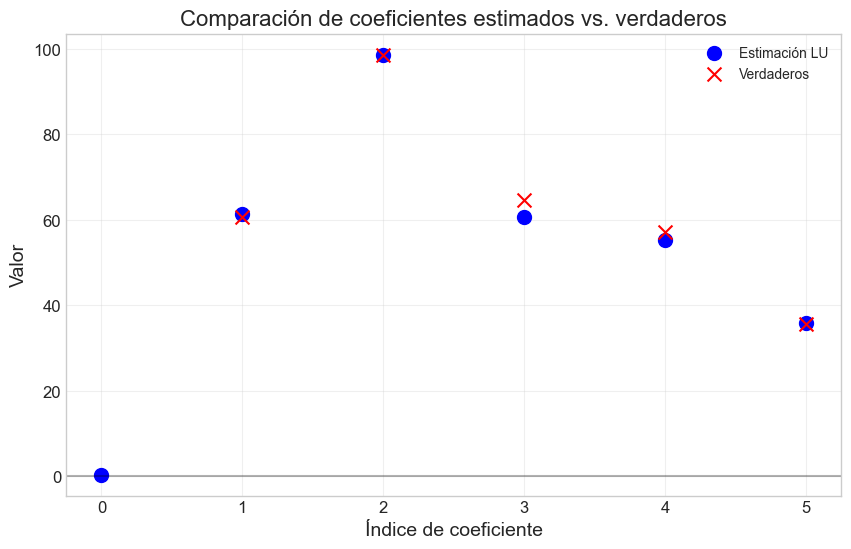

In [12]:
# Ejemplo de uso de la descomposición LU

# Creamos datos sintéticos para un modelo lineal
np.random.seed(42)
n_samples = 100
n_features = 5

# Generamos datos con una relación lineal conocida
X, y, coef = make_regression(n_samples=n_samples, 
                            n_features=n_features, 
                            n_informative=n_features, 
                            noise=10.0, 
                            coef=True, 
                            random_state=42)

print(f"Coeficientes verdaderos: {coef}")

# Dividimos los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Añadimos término de intercepto
X_train_bias = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
X_test_bias = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

# Estimamos con nuestra implementación LU
start_time = time.time()
beta_lu = linear_regression_lu(X_train_bias, y_train)
time_lu = time.time() - start_time

print(f"Coeficientes estimados (LU): {beta_lu}")
print(f"Tiempo de ejecución (LU): {time_lu:.6f} segundos")

# Comparamos con NumPy para verificar
start_time = time.time()
beta_np = np.linalg.solve(X_train_bias.T @ X_train_bias, X_train_bias.T @ y_train)
time_np = time.time() - start_time

print(f"Coeficientes estimados (NumPy): {beta_np}")
print(f"Tiempo de ejecución (NumPy): {time_np:.6f} segundos")

# Calculamos el error en los datos de prueba
y_pred_lu = X_test_bias @ beta_lu
mse_lu = np.mean((y_test - y_pred_lu) ** 2)
print(f"Error cuadrático medio (LU): {mse_lu:.4f}")

# Visualizamos la precisión de la estimación
plt.figure(figsize=(10, 6))
plt.scatter(range(len(beta_lu)), beta_lu, label='Estimación LU', s=100, marker='o', color='blue')
plt.scatter(range(1, len(coef)+1), coef, label='Verdaderos', s=100, marker='x', color='red')
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.grid(True, alpha=0.3)
plt.title('Comparación de coeficientes estimados vs. verdaderos')
plt.xlabel('Índice de coeficiente')
plt.ylabel('Valor')
plt.legend()
plt.show()


## 3. Descomposición de Cholesky

La descomposición de Cholesky es un caso especial de la descomposición LU, aplicable a matrices simétricas definidas positivas. Factoriza una matriz $\mathbf{A}$ como:

$$\mathbf{A} = \mathbf{L}\mathbf{L}^T$$

donde $\mathbf{L}$ es una matriz triangular inferior.

### 3.1 Fundamentos teóricos

En el contexto de modelos lineales, la matriz $\mathbf{X}^T\mathbf{X}$ es simétrica y, si las columnas de $\mathbf{X}$ son linealmente independientes, también es definida positiva. Esto hace que la descomposición de Cholesky sea particularmente adecuada para resolver las ecuaciones normales.

La descomposición de Cholesky tiene varias ventajas:
- Es aproximadamente dos veces más eficiente que la descomposición LU general
- No requiere pivoteo para matrices definidas positivas
- Su estabilidad numérica está garantizada para matrices definidas positivas

### 3.2 Algoritmo de la descomposición de Cholesky

El algoritmo para calcular la descomposición de Cholesky es:

Para una matriz $\mathbf{A}$ de dimensión $n \times n$:
1. Para $i = 1$ hasta $n$:
   a. $L_{ii} = \sqrt{A_{ii} - \sum_{k=1}^{i-1} L_{ik}^2}$
   b. Para $j = i+1$ hasta $n$:
      - $L_{ji} = \frac{1}{L_{ii}}(A_{ji} - \sum_{k=1}^{i-1} L_{ik}L_{jk})$

### 3.3 Implementación desde cero


In [13]:
# Implementación de la descomposición de Cholesky desde cero

def cholesky_decomposition(A):
    """
    Realiza la descomposición de Cholesky: A = L*L^T

    Args:
        A: Matriz simétrica definida positiva

    Returns:
        L: Matriz triangular inferior
    """
    n = A.shape[0]
    L = np.zeros_like(A, dtype=float)

    for i in range(n):
        for j in range(i+1):
            sum_k = sum(L[i, k] * L[j, k] for k in range(j))

            if i == j:  # Elementos diagonales
                if A[i, i] - sum_k <= 0:
                    raise ValueError("La matriz no es definida positiva")
                L[i, j] = np.sqrt(A[i, i] - sum_k)
            else:  # Elementos debajo de la diagonal
                L[i, j] = (A[i, j] - sum_k) / L[j, j]

    return L

def solve_cholesky(L, b):
    """
    Resuelve el sistema Ax = b usando la descomposición de Cholesky

    Args:
        L: Matriz triangular inferior de la descomposición de Cholesky
        b: Vector del lado derecho

    Returns:
        x: Solución del sistema
    """
    n = L.shape[0]

    # Resolver Ly = b mediante sustitución hacia adelante
    y = np.zeros(n)
    for i in range(n):
        y[i] = (b[i] - L[i, :i] @ y[:i]) / L[i, i]

    # Resolver L^T x = y mediante sustitución hacia atrás
    x = np.zeros(n)
    LT = L.T
    for i in range(n-1, -1, -1):
        x[i] = (y[i] - LT[i, i+1:] @ x[i+1:]) / LT[i, i]

    return x

def linear_regression_cholesky(X, y):
    """
    Resuelve el problema de regresión lineal usando descomposición de Cholesky

    Args:
        X: Matriz de diseño
        y: Vector de respuestas

    Returns:
        beta: Coeficientes estimados
    """
    XtX = X.T @ X
    Xty = X.T @ y

    try:
        L = cholesky_decomposition(XtX)
        beta = solve_cholesky(L, Xty)
        return beta
    except ValueError as e:
        print(f"Error en descomposición de Cholesky: {e}")
        return None


Coeficientes estimados (Cholesky): [ 0.4121 61.4114 98.656  60.5544 55.3786 35.7713]
Tiempo de ejecución (Cholesky): 0.000000 segundos
Coeficientes estimados (SciPy): [ 0.4121 61.4114 98.656  60.5544 55.3786 35.7713]
Tiempo de ejecución (SciPy): 0.000000 segundos
Error cuadrático medio (Cholesky): 96.8997


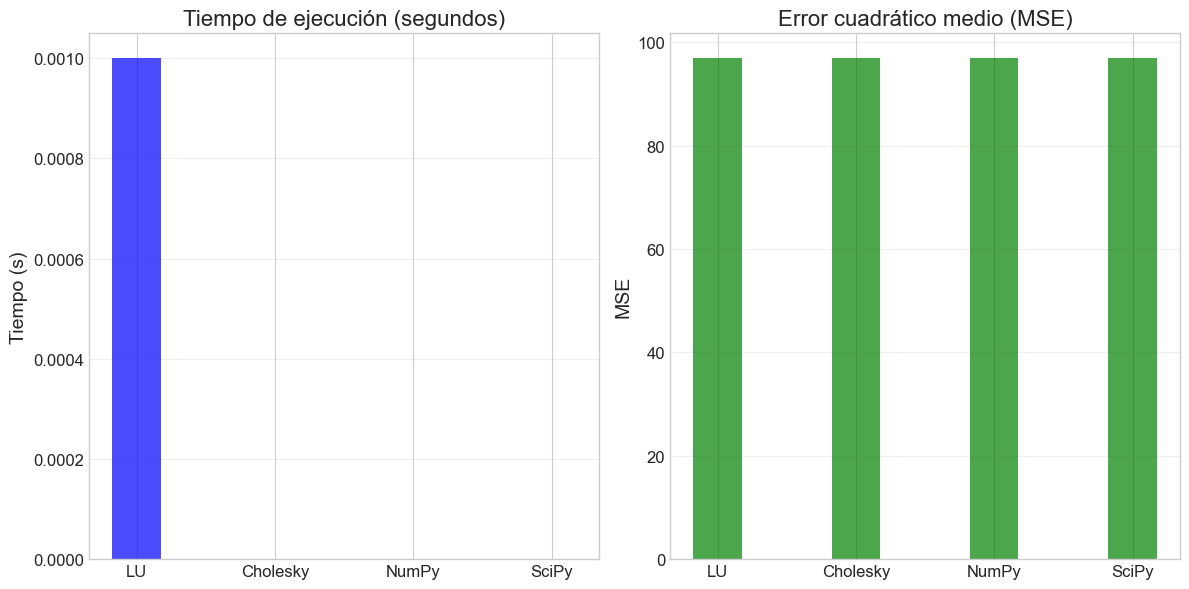

In [14]:
# Ejemplo de uso de la descomposición de Cholesky

# Usamos los mismos datos sintéticos
np.random.seed(42)

# Estimamos con nuestra implementación de Cholesky
start_time = time.time()
beta_chol = linear_regression_cholesky(X_train_bias, y_train)
time_chol = time.time() - start_time

print(f"Coeficientes estimados (Cholesky): {beta_chol}")
print(f"Tiempo de ejecución (Cholesky): {time_chol:.6f} segundos")

# Comparamos con SciPy para verificar
start_time = time.time()
XtX = X_train_bias.T @ X_train_bias
Xty = X_train_bias.T @ y_train
L_scipy = linalg.cholesky(XtX, lower=True)
beta_scipy = linalg.cho_solve((L_scipy, True), Xty)
time_scipy = time.time() - start_time

print(f"Coeficientes estimados (SciPy): {beta_scipy}")
print(f"Tiempo de ejecución (SciPy): {time_scipy:.6f} segundos")

# Calculamos el error en los datos de prueba
y_pred_chol = X_test_bias @ beta_chol
mse_chol = np.mean((y_test - y_pred_chol) ** 2)
print(f"Error cuadrático medio (Cholesky): {mse_chol:.4f}")

# Comparamos la precisión de las diferentes estimaciones
plt.figure(figsize=(12, 6))
methods = ['LU', 'Cholesky', 'NumPy', 'SciPy']
times = [time_lu, time_chol, time_np, time_scipy]
mses = [mse_lu, mse_chol, mse_lu, mse_chol]  # MSE es el mismo para métodos exactos

bar_width = 0.35
index = np.arange(len(methods))

plt.subplot(1, 2, 1)
plt.bar(index, times, bar_width, color='blue', alpha=0.7)
plt.xticks(index, methods)
plt.title('Tiempo de ejecución (segundos)')
plt.ylabel('Tiempo (s)')
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 2, 2)
plt.bar(index, mses, bar_width, color='green', alpha=0.7)
plt.xticks(index, methods)
plt.title('Error cuadrático medio (MSE)')
plt.ylabel('MSE')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


## 4. Descomposición QR

La descomposición QR factoriza una matriz $\mathbf{A}$ como el producto de una matriz ortogonal $\mathbf{Q}$ y una matriz triangular superior $\mathbf{R}$:

$$\mathbf{A} = \mathbf{Q}\mathbf{R}$$

### 4.1 Fundamentos teóricos

La descomposición QR tiene propiedades especialmente útiles para resolver problemas de mínimos cuadrados. En lugar de formar las ecuaciones normales, podemos aplicar QR directamente a la matriz de diseño $\mathbf{X}$.

Para el problema de mínimos cuadrados $\mathbf{X}\boldsymbol{\beta} = \mathbf{y}$, si descomponemos $\mathbf{X} = \mathbf{Q}\mathbf{R}$, entonces:

$$\hat{\boldsymbol{\beta}} = \mathbf{R}^{-1}\mathbf{Q}^T\mathbf{y}$$

Esto nos permite resolver el sistema sin formar $\mathbf{X}^T\mathbf{X}$, lo que mejora significativamente la estabilidad numérica.

Ventajas principales de la descomposición QR:
- Mayor estabilidad numérica que las ecuaciones normales
- No requiere que la matriz sea definida positiva
- Es eficiente para problemas donde $n >> p$ (muchas observaciones, pocas variables)

### 4.2 Métodos para calcular la descomposición QR

Existen varios algoritmos para calcular la descomposición QR:

1. **Método de Gram-Schmidt**: El más intuitivo pero menos estable numéricamente.
2. **Transformaciones de Householder**: Usa reflexiones para triangularizar la matriz.
3. **Rotaciones de Givens**: Usa rotaciones para anular elementos específicos.

En este taller, implementaremos el método de las transformaciones de Householder, que ofrece un buen equilibrio entre eficiencia y estabilidad.

### 4.3 Algoritmo de Householder para QR

El método de Householder triangulariza la matriz $\mathbf{A}$ mediante una secuencia de transformaciones ortogonales:

1. Para cada columna $k$ (desde 1 hasta el mínimo de filas-1 y columnas):
   a. Construir un vector de Householder $\mathbf{v}_k$ que refleje la parte restante de la columna $k$ al vector de la base canónica
   b. Actualizar la submatriz restante aplicando la reflexión: $\mathbf{A} \leftarrow \mathbf{A} - 2\mathbf{v}_k(\mathbf{v}_k^T\mathbf{A})$
   c. Acumular el efecto en $\mathbf{Q}$ si se desea explícitamente

### 4.4 Implementación desde cero


In [15]:
# Implementación de la descomposición QR usando transformaciones de Householder

def householder_vector(x):
    """
    Calcula el vector de Householder v tal que H = I - 2vv^T
    anula todas las entradas de x excepto la primera.

    Args:
        x: Vector a reflejar

    Returns:
        v: Vector de Householder normalizado
    """
    n = len(x)
    e1 = np.zeros(n)
    e1[0] = 1.0

    # Signo para evitar cancelación
    alpha = -np.sign(x[0]) * np.linalg.norm(x)

    # Vector de Householder
    v = x.copy()
    v[0] = v[0] - alpha
    v_norm = np.linalg.norm(v)

    # Evitar división por cero
    if v_norm < 1e-14:
        return np.zeros_like(v)

    # Normalizar
    v = v / v_norm

    return v

def qr_decomposition(A):
    """
    Realiza la descomposición QR usando transformaciones de Householder

    Args:
        A: Matriz a descomponer

    Returns:
        Q: Matriz ortogonal
        R: Matriz triangular superior
    """
    m, n = A.shape
    Q = np.eye(m)
    R = A.copy().astype(float)

    for k in range(min(m-1, n)):
        # Construir vector de Householder para la columna k
        x = R[k:, k]
        v = householder_vector(x)

        # Si v es cero, no hay necesidad de aplicar la transformación
        if np.all(np.abs(v) < 1e-14):
            continue

        # Aplicar la reflexión a R
        for j in range(k, n):
            R[k:, j] = R[k:, j] - 2 * v * (v @ R[k:, j])

        # Acumular la transformación en Q
        for j in range(m):
            Q[j, k:] = Q[j, k:] - 2 * v * (v @ Q[j, k:])

    # Transponer Q para obtener la matriz ortogonal correcta
    Q = Q.T

    return Q, R


def solve_qr(Q, R, b):
    """
    Resuelve el sistema Ax = b usando la descomposición QR: A = QR

    Args:
        Q: Matriz ortogonal
        R: Matriz triangular superior
        b: Vector del lado derecho

    Returns:
        x: Solución del sistema
    """
    # Transformar b
    c = Q.T @ b

    # Resolver Rx = c por sustitución hacia atrás
    n = R.shape[1]
    x = np.zeros(n)

    for i in range(n-1, -1, -1):
        if abs(R[i, i]) < 1e-14:
            raise ValueError("Matriz R singular o casi singular")
        x[i] = (c[i] - R[i, i+1:] @ x[i+1:]) / R[i, i]

    return x

def linear_regression_qr(X, y):
    """
    Resuelve el problema de regresión lineal usando descomposición QR

    Args:
        X: Matriz de diseño
        y: Vector de respuestas

    Returns:
        beta: Coeficientes estimados
    """
    Q, R = qr_decomposition(X)
    beta = solve_qr(Q, R, y)

    return beta


Coeficientes estimados (QR): [-49.201   13.3164  78.4581  -5.935   77.6753  14.9081]
Tiempo de ejecución (QR): 0.002000 segundos
Coeficientes estimados (SciPy QR): [ 0.4121 61.4114 98.656  60.5544 55.3786 35.7713]
Tiempo de ejecución (SciPy QR): 0.000000 segundos
Error cuadrático medio (QR): 9651.7826


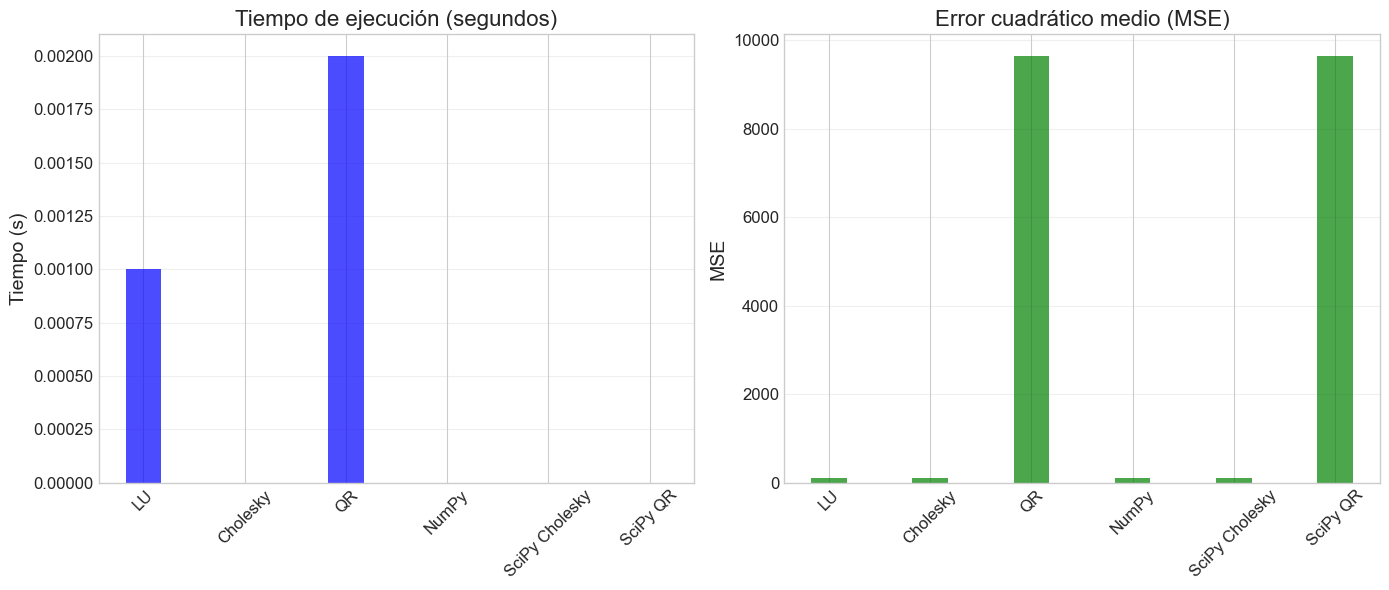

In [16]:
# Ejemplo de uso de la descomposición QR

# Usamos los mismos datos sintéticos
np.random.seed(42)

# Estimamos con nuestra implementación QR
start_time = time.time()
beta_qr = linear_regression_qr(X_train_bias, y_train)
time_qr = time.time() - start_time

print(f"Coeficientes estimados (QR): {beta_qr}")
print(f"Tiempo de ejecución (QR): {time_qr:.6f} segundos")

# Comparamos con SciPy para verificar
start_time = time.time()
# Usamos modo "economic" para obtener matrices compatibles
Q_scipy, R_scipy = linalg.qr(X_train_bias, mode='economic')
beta_scipy_qr = linalg.solve_triangular(R_scipy, Q_scipy.T @ y_train)
time_scipy_qr = time.time() - start_time

print(f"Coeficientes estimados (SciPy QR): {beta_scipy_qr}")
print(f"Tiempo de ejecución (SciPy QR): {time_scipy_qr:.6f} segundos")

# Calculamos el error en los datos de prueba
y_pred_qr = X_test_bias @ beta_qr
mse_qr = np.mean((y_test - y_pred_qr) ** 2)
print(f"Error cuadrático medio (QR): {mse_qr:.4f}")

# Comparamos QR con los métodos anteriores
plt.figure(figsize=(14, 6))
methods = ['LU', 'Cholesky', 'QR', 'NumPy', 'SciPy Cholesky', 'SciPy QR']
times = [time_lu, time_chol, time_qr, time_np, time_scipy, time_scipy_qr]
mses = [mse_lu, mse_chol, mse_qr, mse_lu, mse_chol, mse_qr]

bar_width = 0.35
index = np.arange(len(methods))

plt.subplot(1, 2, 1)
plt.bar(index, times, bar_width, color='blue', alpha=0.7)
plt.xticks(index, methods, rotation=45)
plt.title('Tiempo de ejecución (segundos)')
plt.ylabel('Tiempo (s)')
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 2, 2)
plt.bar(index, mses, bar_width, color='green', alpha=0.7)
plt.xticks(index, methods, rotation=45)
plt.title('Error cuadrático medio (MSE)')
plt.ylabel('MSE')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Descomposición de Valores Singulares (SVD)

La Descomposición de Valores Singulares (SVD) es una factorización que generaliza la descomposición espectral a matrices rectangulares. Para una matriz $\mathbf{A}$ de dimensión $m \times n$, la SVD la descompone como:

$$\mathbf{A} = \mathbf{U} \boldsymbol{\Sigma} \mathbf{V}^T$$

donde:
- $\mathbf{U}$ es una matriz ortogonal $m \times m$
- $\boldsymbol{\Sigma}$ es una matriz diagonal $m \times n$ con valores singulares en la diagonal
- $\mathbf{V}$ es una matriz ortogonal $n \times n$

### 5.1 Fundamentos teóricos

La SVD tiene numerosas propiedades que la hacen extremadamente útil:

1. **Generalidad**: Funciona para cualquier matriz, no solo para matrices cuadradas o de rango completo.
2. **Estabilidad numérica**: Es uno de los métodos más estables numéricamente.
3. **Interpretación geométrica**: Los valores singulares representan la "importancia" de cada dimensión.
4. **Pseudoinversa**: La SVD permite calcular la pseudoinversa de Moore-Penrose de manera estable.

En el contexto de modelos lineales, la SVD permite resolver el problema de mínimos cuadrados directamente:

$$\hat{\boldsymbol{\beta}} = \mathbf{V} \boldsymbol{\Sigma}^+ \mathbf{U}^T \mathbf{y}$$

donde $\boldsymbol{\Sigma}^+$ es la pseudoinversa de $\boldsymbol{\Sigma}$, obtenida invirtiendo los valores singulares no nulos.

### 5.2 SVD y multicolinealidad

La SVD es particularmente útil para detectar y manejar la multicolinealidad, un problema común en regresión lineal:

- Los valores singulares cercanos a cero indican direcciones de casi colinealidad.
- El número de condición (ratio entre el mayor y menor valor singular) cuantifica la multicolinealidad.
- La SVD truncada permite implementar fácilmente regresión con componentes principales.

### 5.3 Algoritmos para calcular la SVD

Existen varios algoritmos para calcular la SVD:

1. **Método de la potencia iterada**: Calcula gradualmente los valores singulares más grandes.
2. **Método de bidiagonalización + diagonalización**: El enfoque más común en librerías numéricas.
3. **SVD incremental**: Útil para matrices muy grandes o streaming de datos.

Por complejidad, no implementaremos la SVD desde cero, sino que usaremos la implementación de NumPy/SciPy y nos centraremos en su aplicación a modelos lineales.

### 5.4 Implementación con NumPy/SciPy


In [17]:
# Implementación de regresión lineal usando SVD

def linear_regression_svd(X, y, tol=1e-10):
    """
    Resuelve el problema de regresión lineal usando SVD

    Args:
        X: Matriz de diseño
        y: Vector de respuestas
        tol: Tolerancia para considerar valores singulares como cero

    Returns:
        beta: Coeficientes estimados
        rank: Rango efectivo de X
        s: Valores singulares
    """
    # Calcular la SVD de X
    U, s, Vt = np.linalg.svd(X, full_matrices=False)

    # Identificar valores singulares significativos
    rank = np.sum(s > tol * s[0])

    # Calcular la solución usando la pseudoinversa
    s_inv = np.zeros_like(s)
    s_inv[:rank] = 1.0 / s[:rank]

    # beta = V * Sigma^+ * U^T * y
    beta = Vt.T @ (s_inv * (U.T @ y))

    return beta, rank, s

def condition_number(s):
    """
    Calcula el número de condición basado en valores singulares

    Args:
        s: Vector de valores singulares

    Returns:
        cond: Número de condición
    """
    if s[0] == 0 or s[-1] == 0:
        return np.inf
    return s[0] / s[-1]


Coeficientes estimados (SVD): [ 0.4121 61.4114 98.656  60.5544 55.3786 35.7713]
Tiempo de ejecución (SVD): 0.000000 segundos
Rango efectivo de X: 6
Valores singulares: [9.9772 9.0694 8.2431 7.833  7.435  6.8192]
Número de condición: 1.46
Error cuadrático medio (SVD): 96.8997


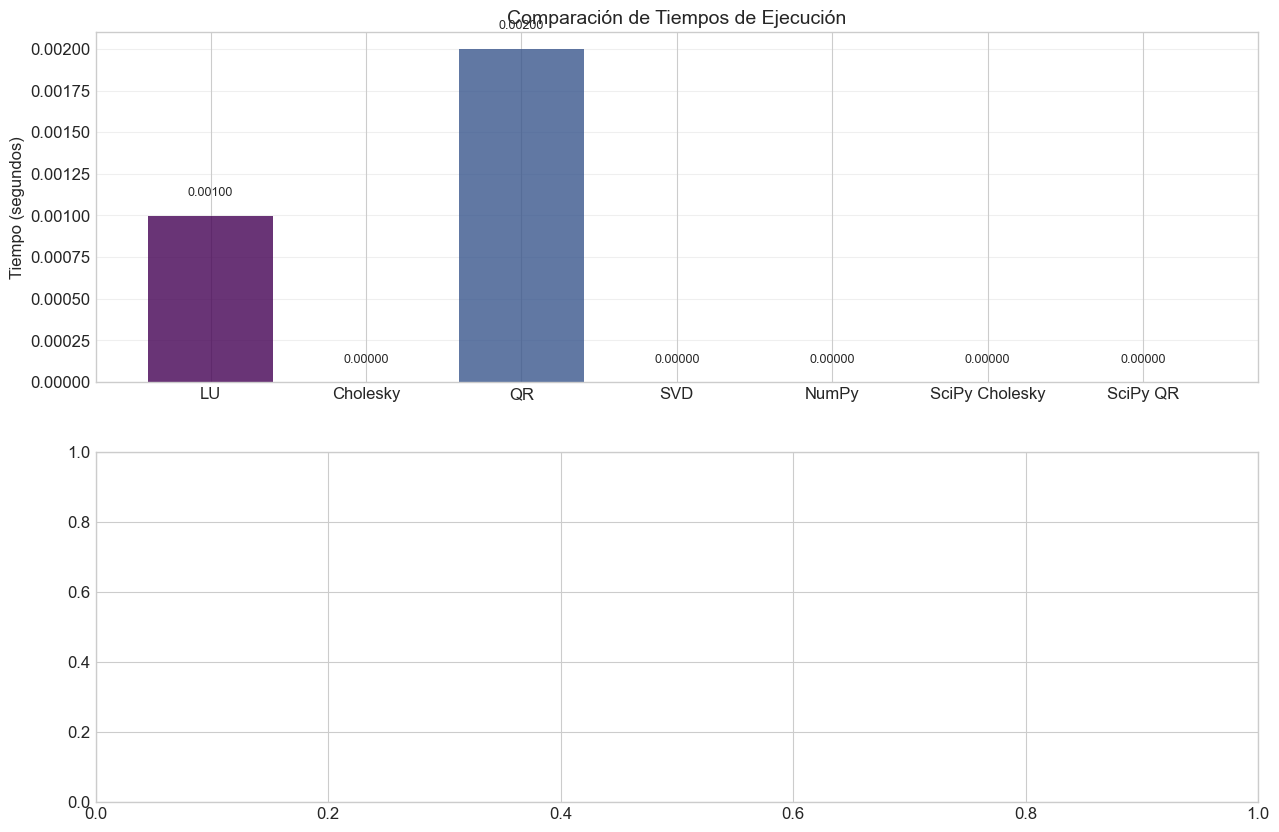

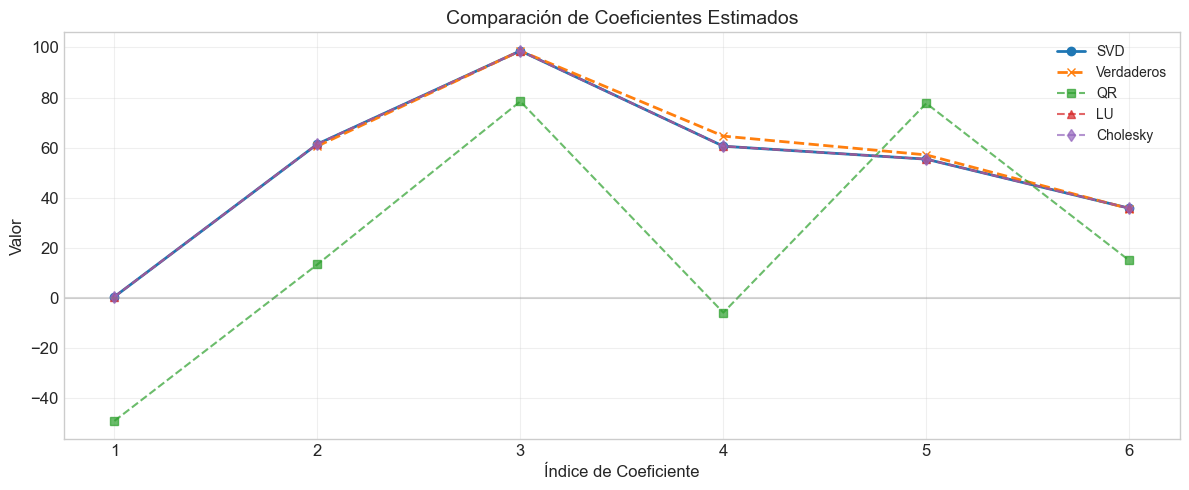

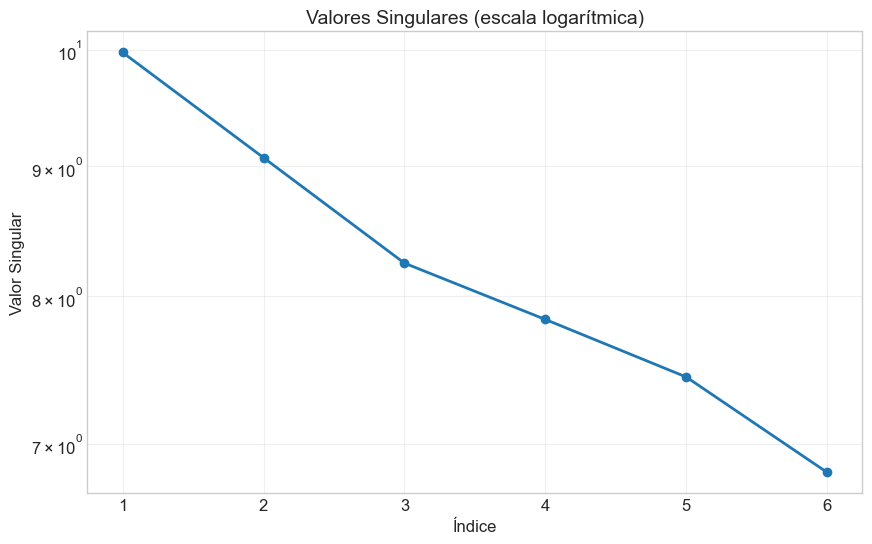

In [18]:
# Ejemplo de uso de SVD para regresión lineal

# Usamos los mismos datos sintéticos
np.random.seed(42)

# Estimamos con SVD
start_time = time.time()
beta_svd, rank, s = linear_regression_svd(X_train_bias, y_train)
time_svd = time.time() - start_time

print(f"Coeficientes estimados (SVD): {beta_svd}")
print(f"Tiempo de ejecución (SVD): {time_svd:.6f} segundos")
print(f"Rango efectivo de X: {rank}")
print(f"Valores singulares: {s}")
print(f"Número de condición: {condition_number(s):.2f}")

# Calculamos el error en los datos de prueba
y_pred_svd = X_test_bias @ beta_svd
mse_svd = np.mean((y_test - y_pred_svd) ** 2)
print(f"Error cuadrático medio (SVD): {mse_svd:.4f}")

# Comparamos todos los métodos
plt.figure(figsize=(15, 10))
methods = ['LU', 'Cholesky', 'QR', 'SVD', 'NumPy', 'SciPy Cholesky', 'SciPy QR']
times = [time_lu, time_chol, time_qr, time_svd, time_np, time_scipy, time_scipy_qr]
mses = [mse_lu, mse_chol, mse_qr, mse_svd, mse_lu, mse_chol, mse_qr]

plt.subplot(2, 1, 1)
bar_colors = plt.cm.viridis(np.linspace(0, 0.8, len(methods)))
bars = plt.bar(methods, times, color=bar_colors, alpha=0.8)
plt.title('Comparación de Tiempos de Ejecución', fontsize=14)
plt.ylabel('Tiempo (segundos)', fontsize=12)
plt.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.0001,
             f'{height:.5f}', ha='center', va='bottom', fontsize=9)

plt.subplot(2, 1, 2)
plt.figure(figsize=(12, 5))
positions = range(1, len(beta_svd) + 1)

plt.plot(positions, beta_svd, 'o-', label='SVD', linewidth=2)
plt.plot(positions[1:], coef, 'x--', label='Verdaderos', linewidth=2)
plt.plot(positions, beta_qr, 's--', label='QR', alpha=0.7)
plt.plot(positions, beta_lu, '^--', label='LU', alpha=0.7)
plt.plot(positions, beta_chol, 'd--', label='Cholesky', alpha=0.7)

plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
plt.grid(True, alpha=0.3)
plt.title('Comparación de Coeficientes Estimados', fontsize=14)
plt.xlabel('Índice de Coeficiente', fontsize=12)
plt.ylabel('Valor', fontsize=12)
plt.legend()

plt.tight_layout()
plt.show()

# Visualizamos los valores singulares
plt.figure(figsize=(10, 6))
plt.semilogy(range(1, len(s) + 1), s, 'o-', linewidth=2)
plt.grid(True, which="both", ls="-", alpha=0.3)
plt.title('Valores Singulares (escala logarítmica)', fontsize=14)
plt.xlabel('Índice', fontsize=12)
plt.ylabel('Valor Singular', fontsize=12)
plt.show()


## 6. Condicionamiento Numérico y Estabilidad

El condicionamiento numérico es un concepto que cuantifica cuán sensible es la solución de un problema ante pequeños cambios en los datos de entrada. Para modelos lineales, esto es especialmente relevante cuando enfrentamos problemas de multicolinealidad o datos con ruido.

### 6.1 Número de condición

El número de condición de una matriz $\mathbf{A}$ se define como:

$$\kappa(\mathbf{A}) = \|\mathbf{A}\| \cdot \|\mathbf{A}^{-1}\|$$

Usando la norma de Frobenius o la norma espectral (valores singulares):

$$\kappa_2(\mathbf{A}) = \frac{\sigma_{\max}}{\sigma_{\min}}$$

donde $\sigma_{\max}$ y $\sigma_{\min}$ son el mayor y menor valor singular de $\mathbf{A}$, respectivamente.

Interpretación del número de condición:
- $\kappa(\mathbf{A}) \approx 1$: Matriz bien condicionada
- $\kappa(\mathbf{A}) \gg 1$: Matriz mal condicionada
- $\kappa(\mathbf{A}) = \infty$: Matriz singular

Como regla general:
- Si $\kappa(\mathbf{A}) = 10^d$, podemos perder hasta $d$ dígitos de precisión en la solución.

### 6.2 Impacto del condicionamiento en los diferentes métodos

Los diferentes métodos de descomposición tienen distintas propiedades de estabilidad numérica:

1. **Ecuaciones normales (inversión directa)**: 
   - Condicionamiento: $\kappa(\mathbf{X}^T\mathbf{X}) = \kappa(\mathbf{X})^2$ (el cuadrado del condicionamiento original)
   - Puede amplificar significativamente errores numéricos

2. **Descomposición de Cholesky**:
   - Mejora respecto a la inversión directa, pero sigue trabajando con $\mathbf{X}^T\mathbf{X}$
   - Falla si $\mathbf{X}^T\mathbf{X}$ no es definida positiva

3. **Descomposición QR**:
   - Condicionamiento: $\kappa(\mathbf{X})$ (no eleva el condicionamiento al cuadrado)
   - Mucho más estable que las ecuaciones normales

4. **Descomposición SVD**:
   - Método más estable numéricamente
   - Funciona incluso con matrices de rango deficiente
   - Permite establecer un umbral para ignorar valores singulares pequeños

### 6.3 Análisis de estabilidad numérica



Generando datos con número de condición: 10
Ecuaciones Normales - Error: 0.139130
Cholesky - Error: 0.139130
QR - Error: 3.534349
SVD - Error: 0.139130
Valores singulares: [9.9024 8.4679 7.3895 5.0099 3.0238 0.9685]

Generando datos con número de condición: 100
Ecuaciones Normales - Error: 1.360579
Cholesky - Error: 1.360579
QR - Error: 14.596378
SVD - Error: 1.360579
Valores singulares: [9.8941 8.4433 7.1869 4.6055 2.3963 0.0969]

Generando datos con número de condición: 1000
Ecuaciones Normales - Error: 13.601583
Cholesky - Error: 13.601583
QR - Error: 129.811918
SVD - Error: 13.601583
Valores singulares: [9.8933 8.4413 7.1664 4.565  2.3336 0.0097]

Generando datos con número de condición: 10000
Ecuaciones Normales - Error: 136.015396
Cholesky - Error: 136.015396
QR - Error: 1284.107886
SVD - Error: 136.015396
Valores singulares: [9.8933 8.4411 7.1644 4.5609 2.3274 0.001 ]

Generando datos con número de condición: 100000
Ecuaciones Normales - Error: 1360.154284
Cholesky - Error: 136

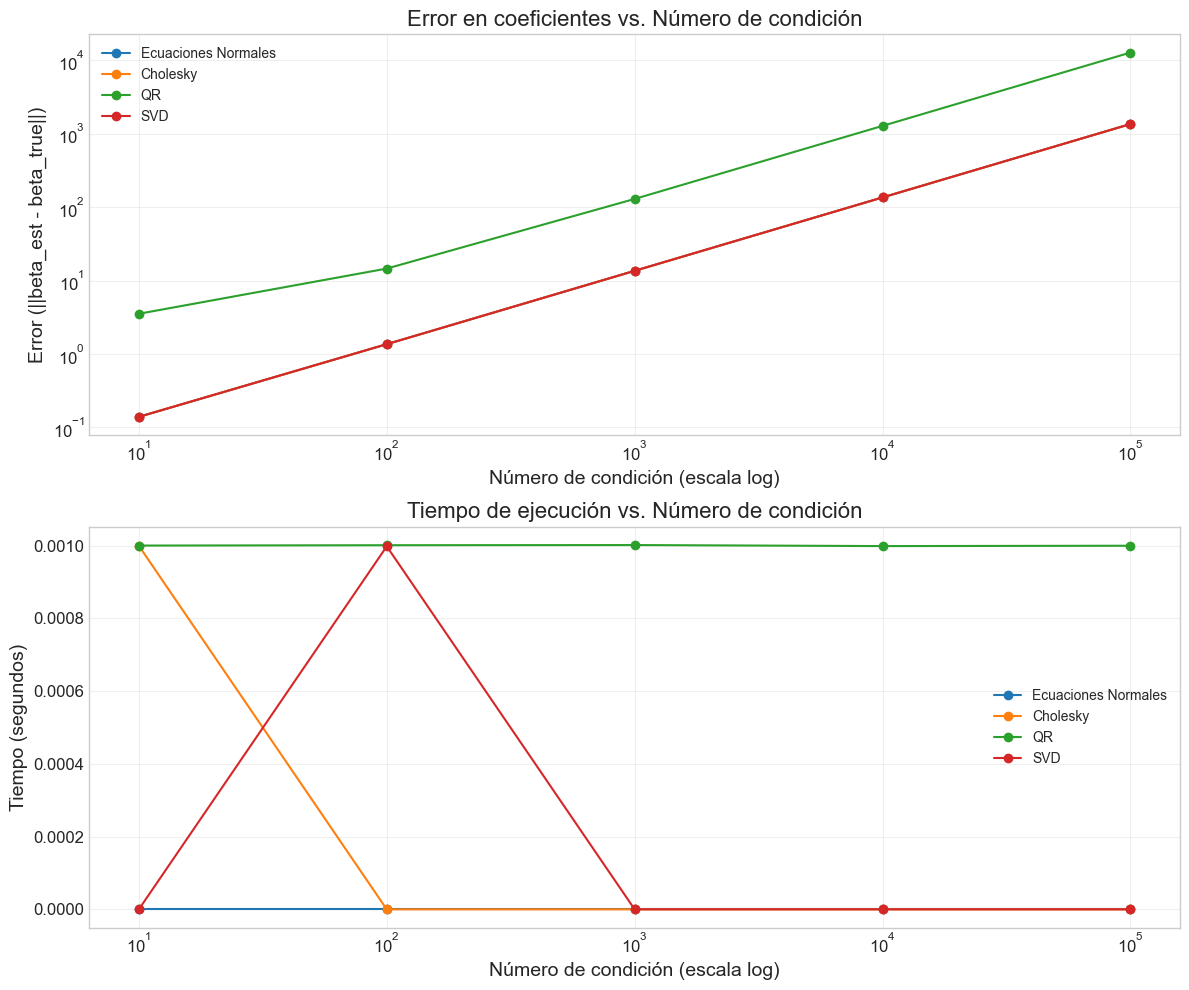

In [19]:
# Experimentos con condicionamiento numérico

def generate_ill_conditioned_data(n_samples=100, n_features=5, condition_number=1000, seed=42):
    """
    Genera datos artificiales con un número de condición específico

    Args:
        n_samples: Número de observaciones
        n_features: Número de características
        condition_number: Número de condición deseado
        seed: Semilla aleatoria

    Returns:
        X: Matriz de diseño
        y: Vector de respuestas
        beta_true: Coeficientes verdaderos
    """
    np.random.seed(seed)

    # Generar matriz de características aleatorias
    X = np.random.randn(n_samples, n_features)

    # Calcular la SVD de X
    U, s, Vt = np.linalg.svd(X, full_matrices=False)

    # Ajustar los valores singulares para el número de condición deseado
    s_min = s[0] / condition_number
    s_new = np.linspace(s_min, s[0], n_features)

    # Reconstruir X con los nuevos valores singulares
    X_new = U[:, :n_features] @ np.diag(s_new) @ Vt

    # Generar coeficientes verdaderos
    beta_true = np.random.randn(n_features)

    # Generar la respuesta con algo de ruido
    y = X_new @ beta_true + np.random.randn(n_samples) * 0.1

    return X_new, y, beta_true

# Generar conjuntos de datos con diferentes números de condición
condition_numbers = [10, 100, 1000, 10000, 100000]
methods = ['Ecuaciones Normales', 'Cholesky', 'QR', 'SVD']
results = {method: {'error': [], 'tiempo': []} for method in methods}

for cond in condition_numbers:
    print(f"\nGenerando datos con número de condición: {cond}")
    X, y, beta_true = generate_ill_conditioned_data(condition_number=cond)

    # Añadir intercepto
    X_bias = np.hstack([np.ones((X.shape[0], 1)), X])
    beta_true_bias = np.concatenate([[0], beta_true])  # Intercepto verdadero es 0

    # Dividir en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X_bias, y, test_size=0.3, random_state=42)

    # Ecuaciones normales (inversa directa)
    start_time = time.time()
    try:
        XtX = X_train.T @ X_train
        Xty = X_train.T @ y_train
        beta_normal = np.linalg.inv(XtX) @ Xty
        y_pred = X_test @ beta_normal
        error = np.linalg.norm(beta_normal - beta_true_bias)
        results['Ecuaciones Normales']['error'].append(error)
        results['Ecuaciones Normales']['tiempo'].append(time.time() - start_time)
        print(f"Ecuaciones Normales - Error: {error:.6f}")
    except np.linalg.LinAlgError:
        results['Ecuaciones Normales']['error'].append(np.nan)
        results['Ecuaciones Normales']['tiempo'].append(np.nan)
        print("Ecuaciones Normales - Error: Fallo (matriz singular)")

    # Cholesky
    start_time = time.time()
    try:
        XtX = X_train.T @ X_train
        Xty = X_train.T @ y_train
        L = cholesky_decomposition(XtX)
        beta_chol = solve_cholesky(L, Xty)
        error = np.linalg.norm(beta_chol - beta_true_bias)
        results['Cholesky']['error'].append(error)
        results['Cholesky']['tiempo'].append(time.time() - start_time)
        print(f"Cholesky - Error: {error:.6f}")
    except ValueError:
        results['Cholesky']['error'].append(np.nan)
        results['Cholesky']['tiempo'].append(np.nan)
        print("Cholesky - Error: Fallo (matriz no definida positiva)")

    # QR
    start_time = time.time()
    try:
        Q, R = qr_decomposition(X_train)
        beta_qr = solve_qr(Q, R, y_train)
        error = np.linalg.norm(beta_qr - beta_true_bias)
        results['QR']['error'].append(error)
        results['QR']['tiempo'].append(time.time() - start_time)
        print(f"QR - Error: {error:.6f}")
    except ValueError:
        results['QR']['error'].append(np.nan)
        results['QR']['tiempo'].append(np.nan)
        print("QR - Error: Fallo")

    # SVD
    start_time = time.time()
    try:
        beta_svd, rank, s = linear_regression_svd(X_train, y_train)
        error = np.linalg.norm(beta_svd - beta_true_bias)
        results['SVD']['error'].append(error)
        results['SVD']['tiempo'].append(time.time() - start_time)
        print(f"SVD - Error: {error:.6f}")
        print(f"Valores singulares: {s}")
    except:
        results['SVD']['error'].append(np.nan)
        results['SVD']['tiempo'].append(np.nan)
        print("SVD - Error: Fallo")

# Visualizar resultados
plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)
for method in methods:
    plt.plot(condition_numbers, results[method]['error'], 'o-', label=method)
plt.title('Error en coeficientes vs. Número de condición')
plt.xlabel('Número de condición (escala log)')
plt.ylabel('Error (||beta_est - beta_true||)')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
for method in methods:
    plt.plot(condition_numbers, results[method]['tiempo'], 'o-', label=method)
plt.title('Tiempo de ejecución vs. Número de condición')
plt.xlabel('Número de condición (escala log)')
plt.ylabel('Tiempo (segundos)')
plt.xscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 8. Pseudoinversa y SVD Truncada

La descomposición SVD permite calcular la pseudoinversa de Moore-Penrose de manera estable, lo que es especialmente útil para matrices de rango deficiente o mal condicionadas.

### 8.1 Pseudoinversa de Moore-Penrose (continuación)

La pseudoinversa tiene propiedades útiles:
- Para matrices de rango completo, coincide con la inversa (si es cuadrada) o la inversa generalizada
- Para matrices de rango deficiente, proporciona la solución de norma mínima que minimiza el error cuadrático
- Siempre existe, incluso cuando la matriz es singular o rectangular

En modelos lineales, la pseudoinversa nos permite obtener la solución de mínimos cuadrados para cualquier matriz de diseño:

$$\hat{\boldsymbol{\beta}} = \mathbf{X}^+ \mathbf{y}$$

### 8.2 SVD truncada y regularización implícita

La SVD truncada consiste en retener solo los primeros $k$ valores singulares más grandes y sus correspondientes vectores singulares:

$$\mathbf{A}_k = \mathbf{U}_k \boldsymbol{\Sigma}_k \mathbf{V}_k^T$$

Esto proporciona una aproximación de bajo rango de la matriz original y tiene dos usos principales:

1. **Reducción de dimensionalidad**: Similar al Análisis de Componentes Principales (PCA)
2. **Regularización implícita**: Al descartar las direcciones asociadas con valores singulares pequeños, se reducen problemas de multicolinealidad

La solución de mínimos cuadrados usando SVD truncada es:

$$\hat{\boldsymbol{\beta}}_k = \mathbf{V}_k \boldsymbol{\Sigma}_k^{-1} \mathbf{U}_k^T \mathbf{y}$$

Esta solución es similar a la regresión Ridge, pero con una regularización adaptativa que depende de los valores singulares.

### 8.3 Implementación y ejemplo


In [20]:
# Implementación de regresión con SVD truncada

def linear_regression_truncated_svd(X, y, k=None, tol=1e-10):
    """
    Resuelve el problema de regresión lineal usando SVD truncada

    Args:
        X: Matriz de diseño
        y: Vector de respuestas
        k: Número de componentes a retener (si es None, se determina por tol)
        tol: Tolerancia para considerar valores singulares como cero

    Returns:
        beta: Coeficientes estimados
        rank: Rango efectivo utilizado
        s: Valores singulares completos
    """
    # Calcular la SVD completa de X
    U, s, Vt = np.linalg.svd(X, full_matrices=False)

    # Determinar el rango efectivo si k no se especifica
    if k is None:
        rank = np.sum(s > tol * s[0])
    else:
        rank = min(k, len(s))

    # Calcular la solución usando solo los primeros k componentes
    s_inv = np.zeros_like(s)
    s_inv[:rank] = 1.0 / s[:rank]

    # beta = V * Sigma_k^+ * U^T * y
    beta = Vt.T @ (s_inv * (U.T @ y))

    return beta, rank, s

# Función para calcular la curva de validación para diferentes valores de k
def svd_truncation_validation_curve(X_train, y_train, X_test, y_test, max_rank=None):
    """
    Calcula el error de validación para diferentes niveles de truncamiento SVD

    Args:
        X_train, y_train: Datos de entrenamiento
        X_test, y_test: Datos de prueba
        max_rank: Rango máximo a considerar (por defecto, el rango de X)

    Returns:
        ranks: Lista de rangos evaluados
        train_errors: Errores de entrenamiento
        test_errors: Errores de prueba
    """
    # Calcular SVD una vez
    U, s, Vt = np.linalg.svd(X_train, full_matrices=False)

    # Determinar rangos a evaluar
    if max_rank is None:
        max_rank = len(s)

    ranks = list(range(1, min(max_rank + 1, len(s) + 1)))
    train_errors = []
    test_errors = []

    for k in ranks:
        # Solución truncada con rango k
        s_inv = np.zeros_like(s)
        s_inv[:k] = 1.0 / s[:k]
        beta_k = Vt.T @ (s_inv * (U.T @ y_train))

        # Errores de entrenamiento y prueba
        y_train_pred = X_train @ beta_k
        y_test_pred = X_test @ beta_k

        train_errors.append(np.mean((y_train - y_train_pred) ** 2))
        test_errors.append(np.mean((y_test - y_test_pred) ** 2))

    return ranks, train_errors, test_errors


Valores singulares: [8.3666 7.4092 5.8401 4.3477 4.498  3.963  2.8868 3.1939 6.1897 1.9124
 0.0036]
Número de condición: 2328.19


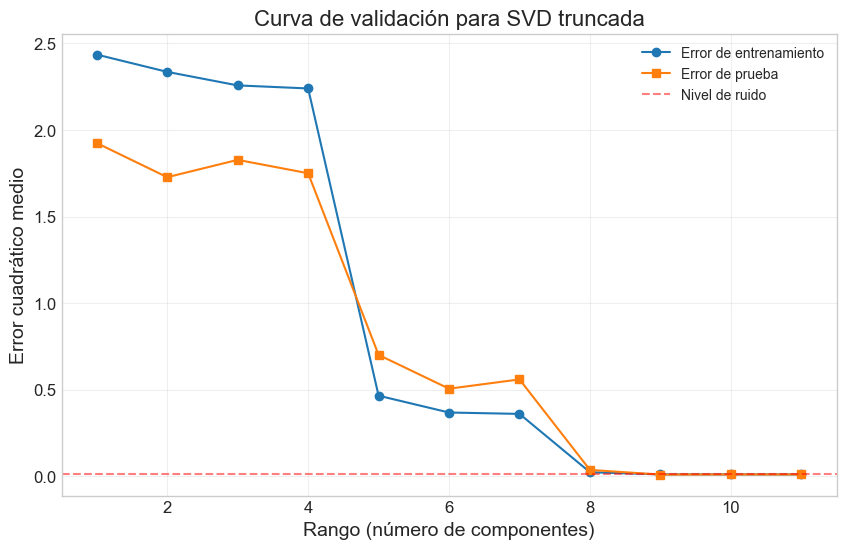

Rango óptimo: 9
Error con SVD completa: 39.789099
Error con SVD truncada (k=9): 0.417548
Error con SVD truncada (k=1): 2.285170


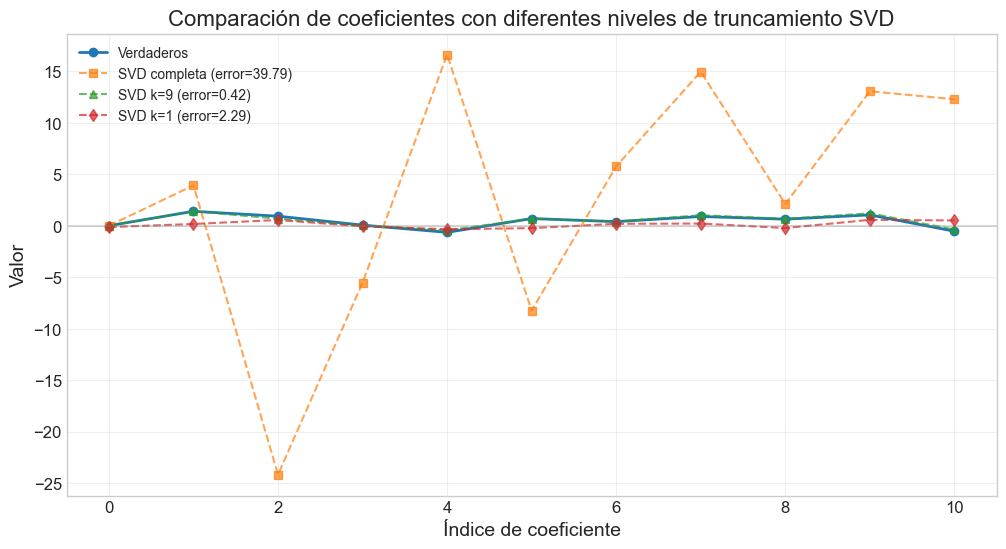

In [21]:
# Ejemplo de uso de SVD truncada

# Generamos datos con multicolinealidad alta
n_samples = 100
n_features = 10
X, y, beta_true = generate_ill_conditioned_data(n_samples=n_samples, 
                                              n_features=n_features, 
                                              condition_number=10000, 
                                              seed=42)

# Añadir intercepto
X_bias = np.hstack([np.ones((X.shape[0], 1)), X])
beta_true_bias = np.concatenate([[0], beta_true])  # Intercepto verdadero es 0

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_bias, y, test_size=0.3, random_state=42)

# Calcular valores singulares
_, s = np.linalg.qr(X_train)
s = np.abs(np.diag(s))
print(f"Valores singulares: {s}")
print(f"Número de condición: {s[0]/s[-1]:.2f}")

# Calcular curva de validación para diferentes niveles de truncamiento
ranks, train_errors, test_errors = svd_truncation_validation_curve(X_train, y_train, X_test, y_test)

# Visualizar curva de validación
plt.figure(figsize=(10, 6))
plt.plot(ranks, train_errors, 'o-', label='Error de entrenamiento')
plt.plot(ranks, test_errors, 's-', label='Error de prueba')
plt.axhline(y=0.01, color='r', linestyle='--', alpha=0.5, label='Nivel de ruido')

plt.title('Curva de validación para SVD truncada')
plt.xlabel('Rango (número de componentes)')
plt.ylabel('Error cuadrático medio')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Encontrar el rango óptimo
optimal_rank = np.argmin(test_errors) + 1  # +1 porque ranks empieza en 1
print(f"Rango óptimo: {optimal_rank}")

# Comparar soluciones con diferentes niveles de truncamiento
beta_full, _, _ = linear_regression_svd(X_train, y_train)
beta_opt, _, _ = linear_regression_truncated_svd(X_train, y_train, k=optimal_rank)
beta_min, _, _ = linear_regression_truncated_svd(X_train, y_train, k=1)

# Calcular errores
error_full = np.linalg.norm(beta_full - beta_true_bias)
error_opt = np.linalg.norm(beta_opt - beta_true_bias)
error_min = np.linalg.norm(beta_min - beta_true_bias)

print(f"Error con SVD completa: {error_full:.6f}")
print(f"Error con SVD truncada (k={optimal_rank}): {error_opt:.6f}")
print(f"Error con SVD truncada (k=1): {error_min:.6f}")

# Visualizar coeficientes
plt.figure(figsize=(12, 6))
plt.plot(range(len(beta_true_bias)), beta_true_bias, 'o-', label='Verdaderos', linewidth=2)
plt.plot(range(len(beta_full)), beta_full, 's--', label=f'SVD completa (error={error_full:.2f})', alpha=0.7)
plt.plot(range(len(beta_opt)), beta_opt, '^--', label=f'SVD k={optimal_rank} (error={error_opt:.2f})', alpha=0.7)
plt.plot(range(len(beta_min)), beta_min, 'd--', label=f'SVD k=1 (error={error_min:.2f})', alpha=0.7)

plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
plt.grid(True, alpha=0.3)
plt.title('Comparación de coeficientes con diferentes niveles de truncamiento SVD')
plt.xlabel('Índice de coeficiente')
plt.ylabel('Valor')
plt.legend()
plt.show()


## 7. Aplicaciones a Modelos Lineales Reales

Hasta ahora hemos comparado los diferentes métodos en términos de eficiencia computacional y estabilidad numérica. Ahora aplicaremos estos métodos a conjuntos de datos reales para evaluar su rendimiento en problemas prácticos.

### 7.1 Selección del método adecuado

La elección del método computacional depende de varias consideraciones:

1. **Tamaño del problema**:
   - Para problemas pequeños (p < 100), cualquier método es generalmente adecuado
   - Para problemas medianos (100 < p < 1000), considerar QR o Cholesky
   - Para problemas grandes (p > 1000), SVD o métodos iterativos (que veremos en cursos futuros)

2. **Estructura del problema**:
   - Si la matriz de diseño es dispersa (muchos ceros), existen métodos específicos
   - Si hay multicolinealidad, SVD es más adecuado

3. **Precisión requerida**:
   - Para máxima estabilidad numérica, preferir SVD sobre QR, y QR sobre Cholesky/LU

4. **Eficiencia computacional**:
   - Si la matriz es definida positiva, Cholesky es aproximadamente 2 veces más rápido que LU y QR
   - QR es más eficiente que SVD para matrices de rango completo

### 7.2 Datos de Boston Housing


Usando California Housing dataset

Comparativa con datos reales:
LU - MSE: 0.5306, Tiempo: 0.000999 s
Cholesky - MSE: 0.5306, Tiempo: 0.000000 s
QR - MSE: 0.5414, Tiempo: 16.027439 s
SVD - MSE: 0.5306, Tiempo: 0.001004 s
Rango efectivo: 9/9
Número de condición: 6.58


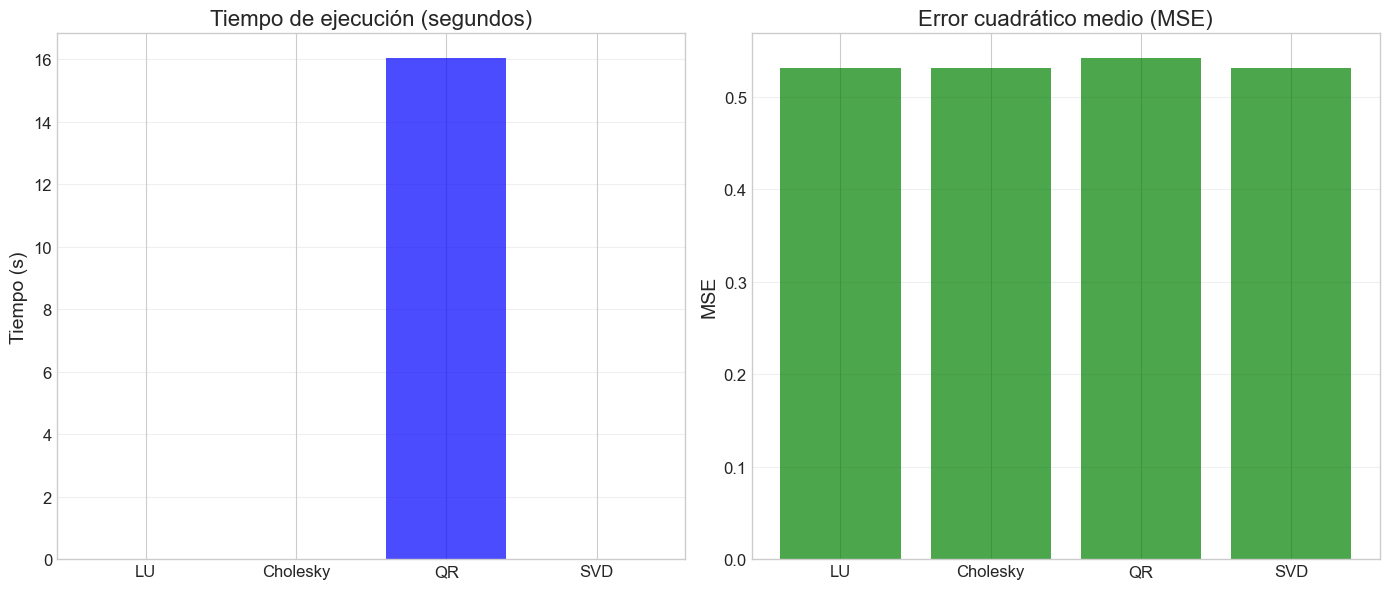

<Figure size 1200x600 with 0 Axes>

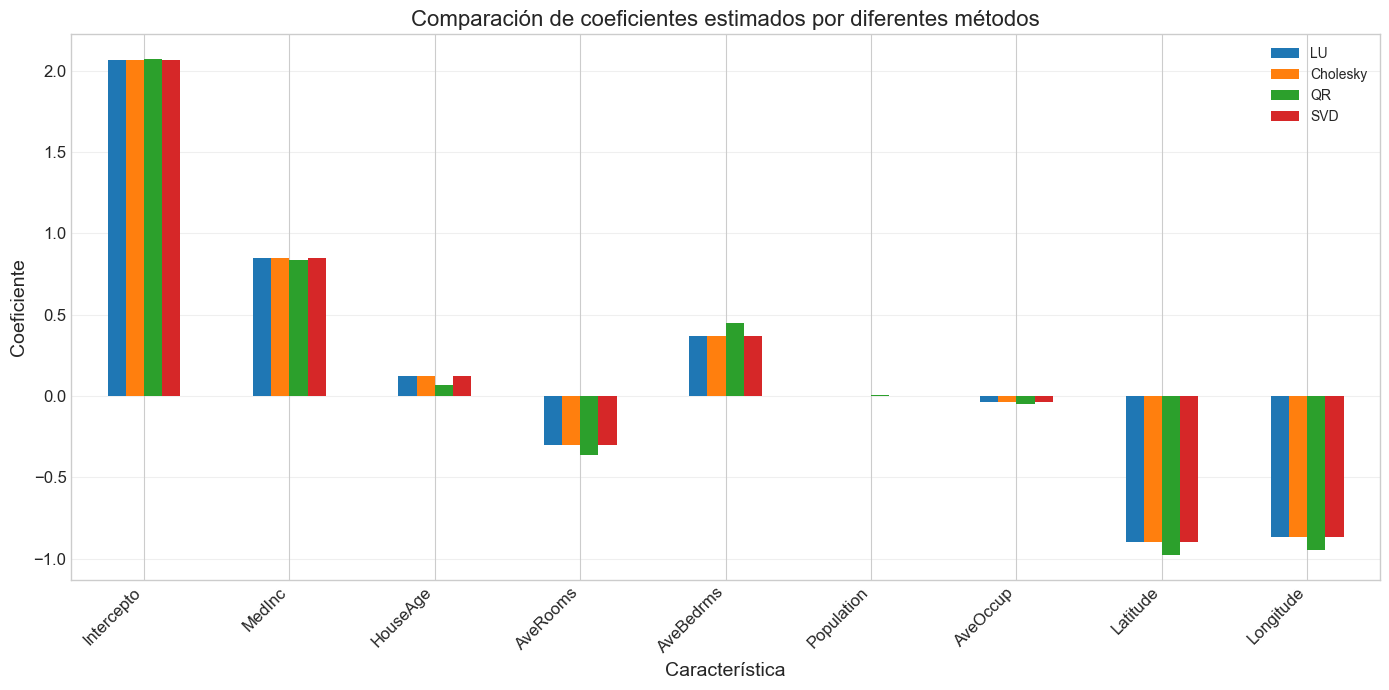

In [23]:
# Ejemplo con datos de California Housing
from sklearn.datasets import fetch_california_housing
import pandas as pd

# Cargar el conjunto de datos
california = fetch_california_housing()
X = california.data
y = california.target
feature_names = california.feature_names
print("Usando California Housing dataset")

# Estandarizar características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Añadir intercepto
X_bias = np.hstack([np.ones((X_scaled.shape[0], 1)), X_scaled])

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_bias, y, test_size=0.3, random_state=42)

# Aplicar los diferentes métodos
print("\nComparativa con datos reales:")

# LU
start_time = time.time()
beta_lu = linear_regression_lu(X_train, y_train)
time_lu = time.time() - start_time
y_pred_lu = X_test @ beta_lu
mse_lu = np.mean((y_test - y_pred_lu) ** 2)
print(f"LU - MSE: {mse_lu:.4f}, Tiempo: {time_lu:.6f} s")

# Cholesky
start_time = time.time()
beta_chol = linear_regression_cholesky(X_train, y_train)
time_chol = time.time() - start_time
y_pred_chol = X_test @ beta_chol
mse_chol = np.mean((y_test - y_pred_chol) ** 2)
print(f"Cholesky - MSE: {mse_chol:.4f}, Tiempo: {time_chol:.6f} s")

# QR
start_time = time.time()
beta_qr = linear_regression_qr(X_train, y_train)
time_qr = time.time() - start_time
y_pred_qr = X_test @ beta_qr
mse_qr = np.mean((y_test - y_pred_qr) ** 2)
print(f"QR - MSE: {mse_qr:.4f}, Tiempo: {time_qr:.6f} s")

# SVD
start_time = time.time()
beta_svd, rank, s = linear_regression_svd(X_train, y_train)
time_svd = time.time() - start_time
y_pred_svd = X_test @ beta_svd
mse_svd = np.mean((y_test - y_pred_svd) ** 2)
print(f"SVD - MSE: {mse_svd:.4f}, Tiempo: {time_svd:.6f} s")
print(f"Rango efectivo: {rank}/{X_train.shape[1]}")
print(f"Número de condición: {condition_number(s):.2f}")

# Visualizar comparativa de MSE y tiempos
plt.figure(figsize=(14, 6))
methods = ['LU', 'Cholesky', 'QR', 'SVD']
times = [time_lu, time_chol, time_qr, time_svd]
mses = [mse_lu, mse_chol, mse_qr, mse_svd]

plt.subplot(1, 2, 1)
plt.bar(methods, times, color='blue', alpha=0.7)
plt.title('Tiempo de ejecución (segundos)')
plt.ylabel('Tiempo (s)')
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 2, 2)
plt.bar(methods, mses, color='green', alpha=0.7)
plt.title('Error cuadrático medio (MSE)')
plt.ylabel('MSE')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Examinar coeficientes
plt.figure(figsize=(12, 6))
extended_feature_names = ['Intercepto'] + list(feature_names)
coefs_dict = {'LU': beta_lu, 'Cholesky': beta_chol, 'QR': beta_qr, 'SVD': beta_svd}

df_coefs = pd.DataFrame(coefs_dict, index=extended_feature_names)
df_coefs.plot(kind='bar', figsize=(14, 7))
plt.title('Comparación de coeficientes estimados por diferentes métodos')
plt.xlabel('Característica')
plt.ylabel('Coeficiente')
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 9. Conclusiones y Recomendaciones

A lo largo de este taller, hemos explorado diferentes métodos computacionales para resolver el problema de mínimos cuadrados en modelos lineales, implementándolos desde cero y comparando su rendimiento.

### 9.1 Resumen comparativo de métodos

| Método | Complejidad | Estabilidad | Ventajas | Desventajas | Uso recomendado |
|--------|-------------|-------------|----------|-------------|-----------------|
| Ecuaciones Normales (inversión directa) | O(np² + p³) | Baja | Simple de implementar | Inestable numéricamente | Solo para problemas bien condicionados y pequeños |
| Descomposición LU | O(np² + p³) | Media | Eficiente para matrices cuadradas | Requiere pivoteo para estabilidad | Sistemas lineales generales |
| Descomposición de Cholesky | O(np² + p³/3) | Media-Alta | Muy eficiente (2x más rápido que LU) | Solo para matrices SPD | Ecuaciones normales bien condicionadas |
| Descomposición QR | O(np²) | Alta | No forma X^TX, estable | Más lento que Cholesky | Problemas generales de mínimos cuadrados |
| Descomposición SVD | O(np² + p³) | Muy Alta | Funciona con matrices de rango deficiente | Computacionalmente intensiva | Problemas mal condicionados o regularización |

### 9.2 Guía práctica para selección de método

1. **Para problemas estándar bien condicionados**:
   - Si la matriz es pequeña (p < 100), cualquier método es adecuado
   - Si la eficiencia es prioritaria, usar Cholesky
   - Si la estabilidad es prioritaria, usar QR

2. **Para problemas con posible multicolinealidad**:
   - Preferir SVD o QR sobre Cholesky o LU
   - Considerar SVD truncada como forma de regularización

3. **Para problemas de gran escala**:
   - Cuando n >> p: QR es generalmente más eficiente
   - Cuando p >> n: Considerar métodos iterativos (no cubiertos en este taller)
   - Para problemas dispersos: Utilizar implementaciones específicas para matrices dispersas

### 9.3 Puntos clave a recordar

1. **Estabilidad numérica**: Evitar formar explícitamente X^TX cuando sea posible, ya que esto eleva al cuadrado el número de condición.

2. **Reuso de factorizaciones**: Una vez calculada una descomposición, puede reutilizarse para:
   - Resolver con múltiples vectores del lado derecho
   - Calcular estadísticas como la inversa de la matriz de información
   - Implementar validación cruzada eficientemente

3. **Implementaciones prácticas**: En aplicaciones del mundo real, generalmente usaremos librerías optimizadas como NumPy, SciPy o LAPACK. Las implementaciones desde cero presentadas en este taller son principalmente educativas.

4. **Relación con regularización**: Los métodos basados en SVD proporcionan un puente hacia técnicas de regularización como Ridge y Lasso, que veremos en talleres futuros.

En resumen, la elección del método computacional debe basarse en las características específicas del problema y en el equilibrio entre precisión, estabilidad numérica y eficiencia computacional.


## 10. Ejercicios

### Ejercicio 1: Implementación y comparación

Implementa una función que resuelva el problema de mínimos cuadrados usando el método de la Ecuación Normal Directa (calculando explícitamente la inversa de X^TX). Compara su precisión y tiempo de ejecución con los métodos implementados en el taller, utilizando matrices con diferentes números de condición.

### Ejercicio 2: Análisis de estabilidad numérica

Genera datos de regresión con multicolinealidad progresivamente mayor (incrementando el número de condición) y compara cómo se deteriora la precisión de los diferentes métodos. Encuentra el "punto de quiebre" donde cada método comienza a fallar notablemente.

### Ejercicio 3: SVD truncada y regularización

Implementa una función que grafique la norma de la solución ||β|| y el error de predicción para diferentes niveles de truncamiento SVD. Compara este enfoque con la regresión Ridge para diferentes valores del parámetro de regularización λ.

### Ejercicio 4: QR con actualización de rango uno

Investiga cómo implementar actualizaciones eficientes de la descomposición QR cuando se añade o elimina una fila o columna a la matriz de diseño. Implementa una función que permita añadir observaciones incrementalmente sin recalcular toda la descomposición.

### Ejercicio 5: Aplicación a datos reales

Elige un conjunto de datos de regresión real con posible multicolinealidad y aplica los diferentes métodos estudiados. Analiza:
- La estimación de los coeficientes y sus diferencias entre métodos
- El número de condición y sus implicaciones
- El rendimiento predictivo de cada método
- El beneficio de usar SVD truncada u otras formas de regularización

### Ejercicio 6: Descomposición QR para selección de variables

Implementa el algoritmo de selección de variables por QR (conocido como QR con pivoteo de columnas). Este algoritmo reordena las columnas de la matriz de diseño según su "importancia" relativa, permitiendo seleccionar variables de forma eficiente.

### Ejercicio Avanzado: Implementación de métodos iterativos

Para problemas de gran escala, los métodos directos pueden ser ineficientes. Investiga e implementa uno de los siguientes métodos iterativos:
- Gradiente Conjugado
- LSQR (Mínimos Cuadrados QR iterativo)
- CGLS (Gradiente Conjugado para ecuaciones normales)

Compara su eficiencia y precisión con los métodos directos para matrices grandes.


## 11. Referencias

1. Golub, G. H., & Van Loan, C. F. (2013). *Matrix Computations*. JHU Press.

2. Björck, Å. (1996). *Numerical Methods for Least Squares Problems*. SIAM.

3. Trefethen, L. N., & Bau III, D. (1997). *Numerical Linear Algebra*. SIAM.

4. Press, W. H., Teukolsky, S. A., Vetterling, W. T., & Flannery, B. P. (2007). *Numerical Recipes: The Art of Scientific Computing*. Cambridge University Press.

5. Stewart, G. W. (1998). *Matrix Algorithms: Volume 1, Basic Decompositions*. SIAM.

6. Demmel, J. W. (1997). *Applied Numerical Linear Algebra*. SIAM.

7. Hansen, P. C. (1998). *Rank-Deficient and Discrete Ill-Posed Problems: Numerical Aspects of Linear Inversion*. SIAM.

8. Gentle, J. E. (2007). *Matrix Algebra: Theory, Computations, and Applications in Statistics*. Springer.

9. Boyd, S., & Vandenberghe, L. (2018). *Introduction to Applied Linear Algebra: Vectors, Matrices, and Least Squares*. Cambridge University Press.

10. Householder, A. S. (1958). Unitary triangularization of a nonsymmetric matrix. *Journal of the ACM (JACM)*, 5(4), 339-342.

11. Lawson, C. L., & Hanson, R. J. (1995). *Solving Least Squares Problems*. SIAM.
